# Image Filtering Module: Features

**Notes from Hany Farid's Computer Vision Course (UC Berkley)**
https://farid.berkeley.edu/downloads/tutorials/learnComputerVision/

In [14]:
# Imports for this notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sepfir2d
from skimage.feature import hog
from skimage import data, exposure

## Edge Detection

### Exercise #9: Compute directional derivatives
> Write some code to compute directional derivatives by steering the horizontal and vertical derivatives:

> $f_\theta = \cos(\theta) f_x + \sin(\theta)f_y $

Starter code was provided:
```
p = [0.030320, 0.249724, 0.439911, 0.249724, 0.030320]
d = [-0.104550, 0.292315, 0.0, 0.292315, 0.104550]

img_x = sepfir2d( img, d, p) # spatial (x) derivative
img_y = sepfir2d( img, p, d) # spatial (y) derivative
```

> "For every theta (say, every 1 degree or 5 degrees), compute the directional derivative and visualize"

(-0.5, 224.5, 223.5, -0.5)

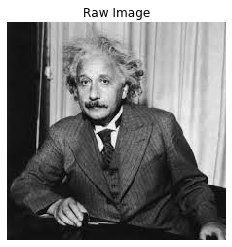

In [15]:
img_raw = 1.0 * plt.imread('../images/einstein.jpeg')
img = np.average(img_raw, axis=-1)

# Provided derivative filters
# These are more accurate than (-1, 1) used in lecture
p = [0.030320, 0.249724, 0.439911, 0.249724, 0.030320] # pre-filter (gaussian blur)
d = [-0.104550, -0.292315, 0.0, 0.292315, 0.104550] # derivative filter

# We'll continue using the Einstein image above, here is the original:
plt.imshow(img, cmap='gray')
plt.title('Raw Image')
plt.axis('off')

(-0.5, 224.5, 223.5, -0.5)

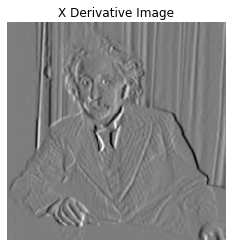

In [16]:
# We'll blur in the y direction and differentiate in the x direction
img_x = sepfir2d( img, d, p) # spatial (x) derivative
plt.imshow(img_x, cmap='gray')
plt.title('X Derivative Image')
plt.axis('off')

(-0.5, 224.5, 223.5, -0.5)

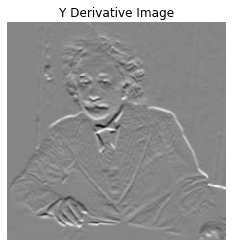

In [17]:
# We'll blur in the x direction and differentiate in the y direction for img_y
img_y = sepfir2d( img, p, d) # spatial (y) derivative
plt.imshow(img_y, cmap='gray')
plt.title('Y Derivative Image')
plt.axis('off')

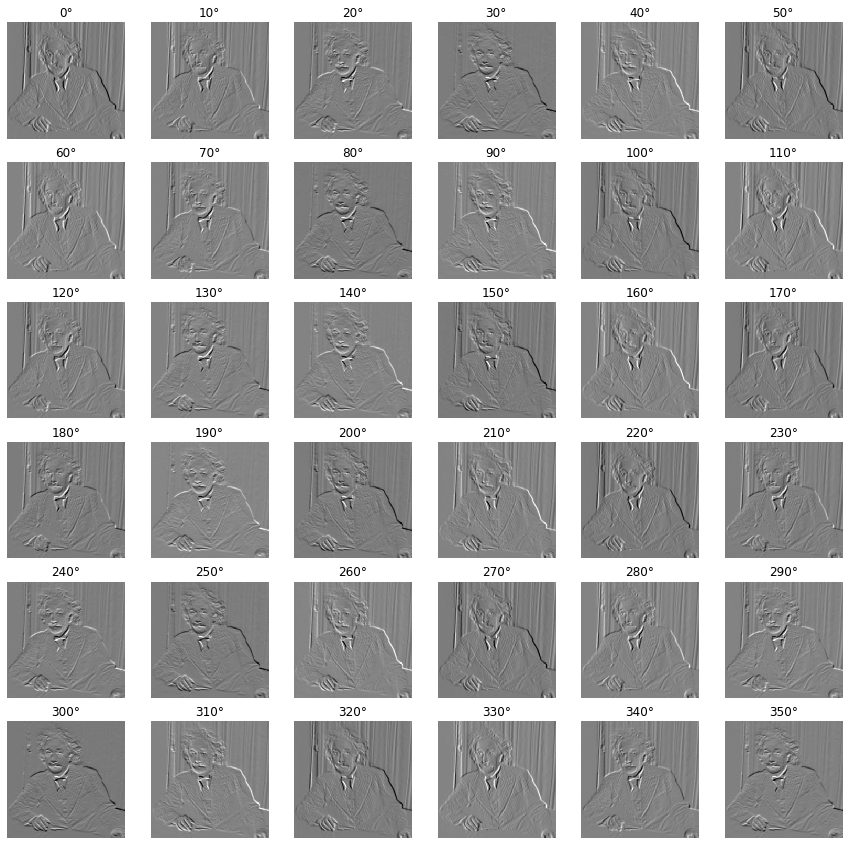

In [18]:
# I'll compute every 10th degree into a 6x6 grid of images, each showing the image for the associated degree of steering
step = 10
rows = 6
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(15,15))

for i in range(0, 360, step):
    pos = i/step
    row = np.floor(pos/cols).astype(int)
    col = np.floor(pos - (row*cols)).astype(int)
    img_d = (np.cos(i) * img_x) + (np.sin(i) * img_y)

    axs[row, col].imshow(img_d, cmap='gray')
    axs[row, col].set_title(f'{i}\N{DEGREE SIGN}')
    axs[row, col].axis('off')

Umm... that doesn't look right!
I didn't convert my theta to radians above... the code below should actually be correct:


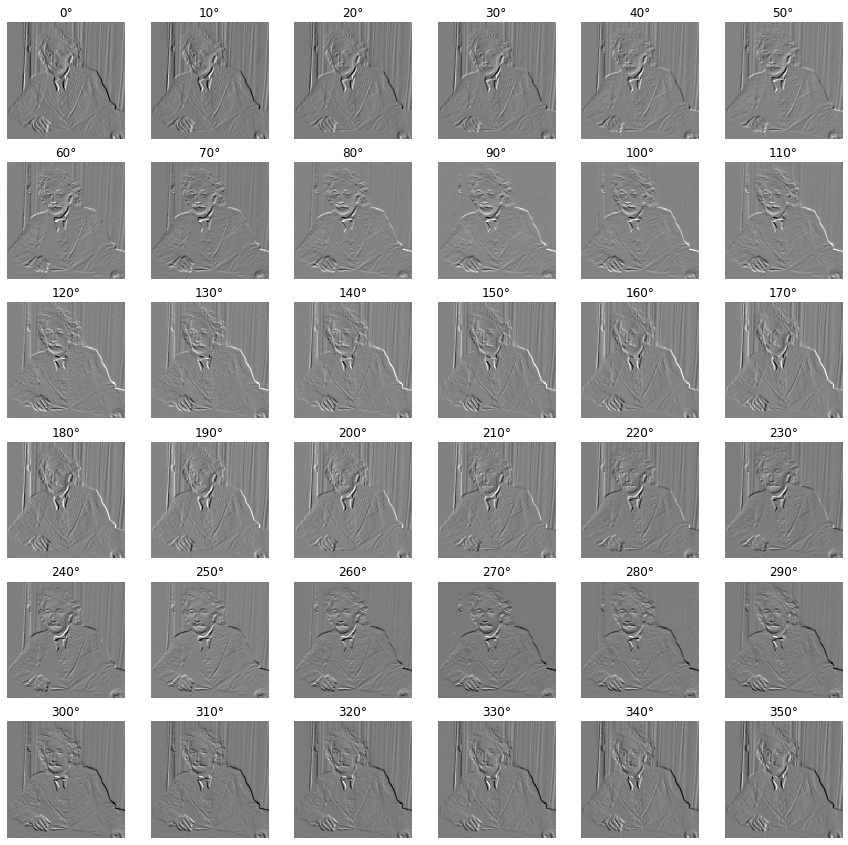

In [19]:
fig, axs = plt.subplots(rows, cols, figsize=(15,15))

for i in range(0, 360, step):
    pos = i/step
    row = np.floor(pos/cols).astype(int)
    col = np.floor(pos - (row*cols)).astype(int)
    
    img_d = (np.cos(np.radians(i)) * img_x) + (np.sin(np.radians(i)) * img_y)

    axs[row, col].imshow(img_d, cmap='gray')
    axs[row, col].set_title(f'{i}\N{DEGREE SIGN}')
    axs[row, col].axis('off')

That makes more sense and highlights the importance of converting degrees into radians!!

## Histogram of Gradients

We learned above that there are two things we can know about an image after deriving the derivative values of $f_x$ and $f_y$ - the magnitude and orientation!

**Magnitude** - This is the overall gradient which tells us how much energy there is at a certain coordinate (how much is the value changing at that location?)

$ f = \sqrt{f_x^2 + f_y^2} $

**Orientation** - This tells us the direction in which our values are changing at a certain location (where $\theta$ below is the angle of the vector from our $f_x$ and $f_y$ basis)

$ \theta = \tan^{-1} \big(\frac{fy}{fx} \big)$

The exercise above showed us the directional derivative (gradient) for different $\theta$ values ... but how can we get a better picture of the amount of energy in each direction with a single representation (instead of a different image for each theta) - we can compute a histogram of the gradients! 

We do this by breaking our image down into smaller squares and computing a summary statistic that captures both the magnitude and gradient for all pixel values in each square. This will give us a pretty good representation of the **amount** of value change and the **direction** of value change in the pixels contained in each "summary square".

So the histogram will be a vector summary of each square where the bins in the histogram are the orientation values for pixels in the summary square and the value for each bin is the sum of gradient values associated with each orientation bin. 

### Exercise #10: Compute the Histogram of Gradients (HOG)

> Write some code to compute the HOG features
> See `skimage.feature.hog` rather than compute the derivatives and orientation yourself

In [20]:
image = plt.imread('../images/einstein.jpeg')

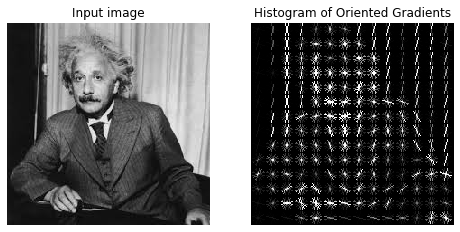

In [21]:
# Code below borrowed from skimage.feature.hog docs - https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


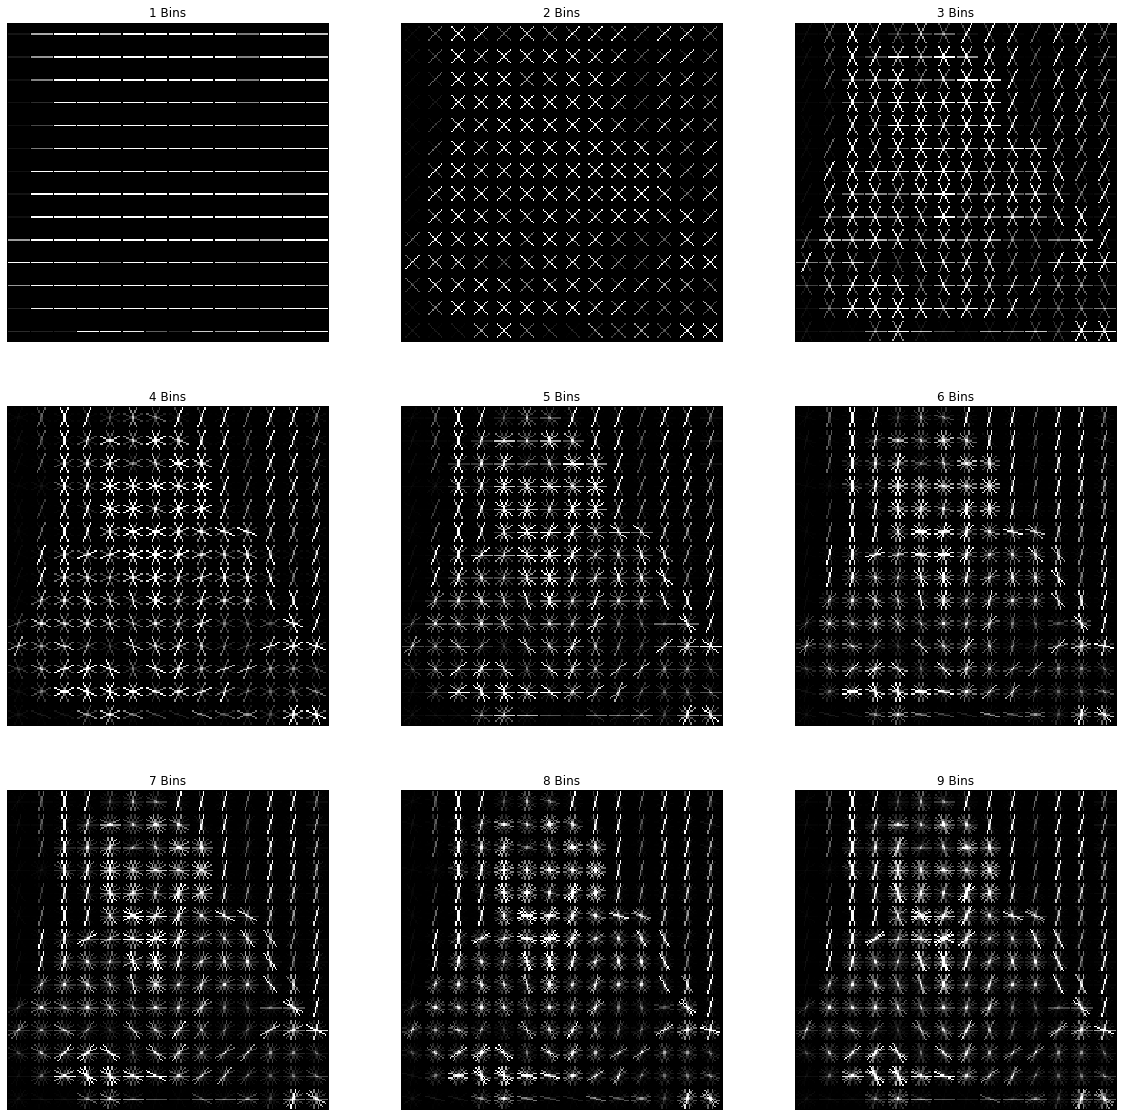

In [22]:
# Super cool!! And we can play with the parameters to see how things change
# For example, when we have different orientations in our histogram we can see how we're recording more or less information:
rows = 3
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)

for i in range(1,rows*cols +1):
    row = np.floor((i-1)/cols).astype(int)
    col = np.floor((i-1) - (row*cols)).astype(int)
    
    fd, hog_image = hog(image, orientations=i, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax[row,col].axis('off')
    ax[row,col].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax[row,col].set_title(f'{i} Bins')


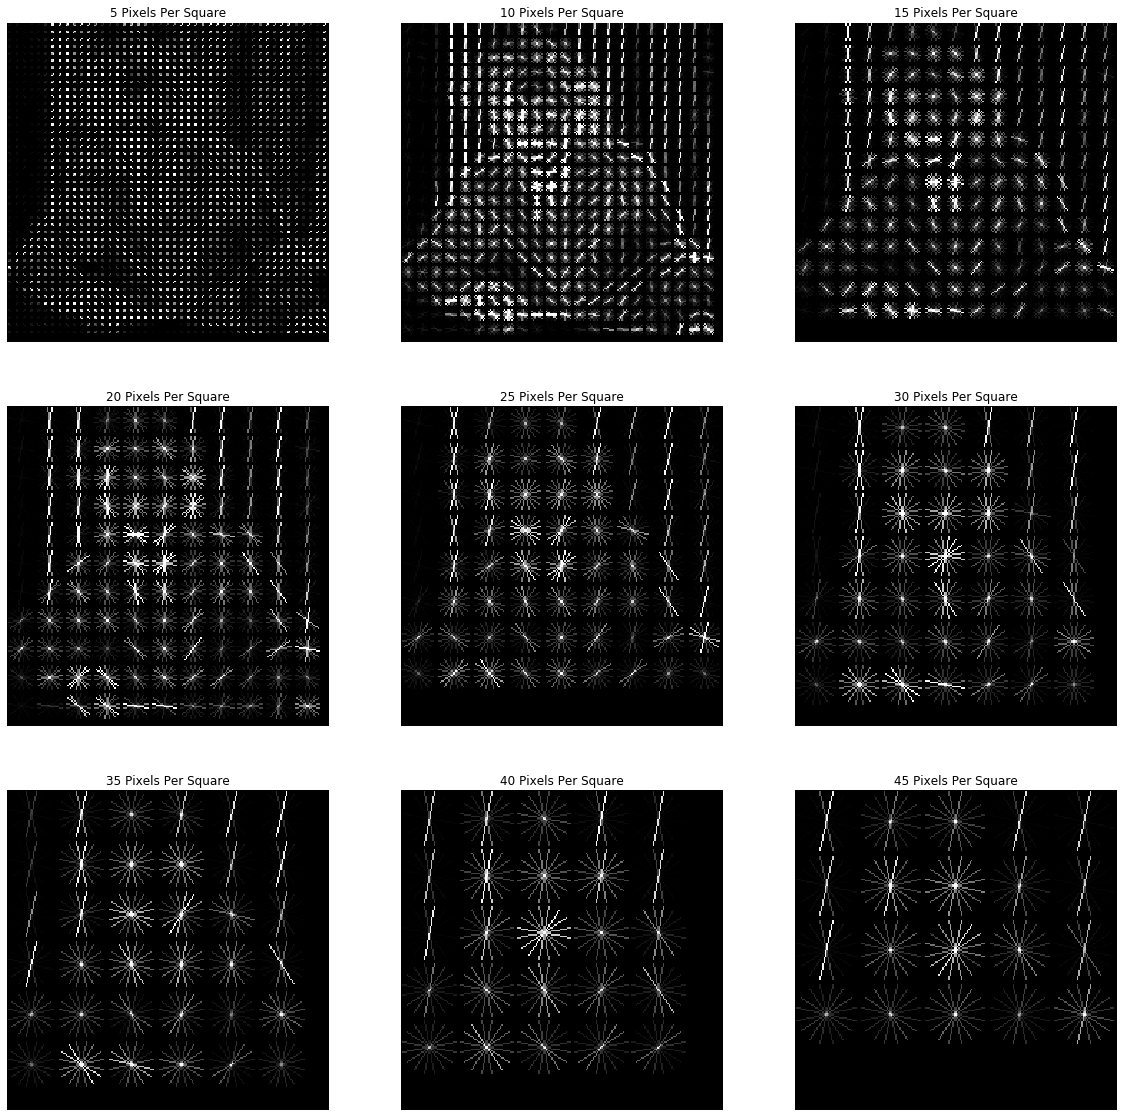

In [23]:
# Similarly, we can see how changing the number of pixels per square impacts the amount of information recorded:
rows = 3
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)

for i in range(1,rows*cols +1):
    scale_i = 5
    row = np.floor((i-1)/cols).astype(int)
    col = np.floor((i-1) - (row*cols)).astype(int)
    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(i*scale_i, i*scale_i),
                    cells_per_block=(1, 1), visualize=True)

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax[row,col].axis('off')
    ax[row,col].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax[row,col].set_title(f'{i*scale_i} Pixels Per Square')